In [1]:
from flows import DFlow, NVPFlow, Normal, LogNormal, floatX
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
data = pd.read_csv('./srrs.csv')

In [3]:
data.columns = ['cnt','rdn','floor']

In [4]:
data['rdn'] = np.log(data['rdn']+1)
data['rdn'] -= data['rdn'].mean()
data['floor'] -= data['floor'].mean()

data['rdn'] /= data['rdn'].std()
data['floor'] /= data['floor'].std()

In [5]:
data.head()

,cnt,rdn,floor
0,AITKIN,-0.619228,-0.445216
1,AITKIN,-0.299988,-0.445216
2,AITKIN,-1.377695,-0.445216
3,ANOKA,-0.219283,-0.445216
4,ANOKA,-0.474617,-0.445216


In [6]:
# le = LabelEncoder()

In [7]:
# data['cnt'] = le.fit_transform(data['cnt'])

In [8]:
global_inf = DFlow([NVPFlow(2, 'global_{}'.format(i)) for i in range(8)])
global_prior = Normal(None, name='global_prior')

In [9]:
presigma = tf.get_variable('presigma', shape=(), dtype=floatX)
sigma = tf.exp(presigma)

In [10]:
observ_d = Normal(None, mu=0, sigma=sigma)

In [11]:
shr_prior = tf.distributions.Exponential(rate=1.)

In [12]:
with tf.variable_scope('hier_hyp', dtype=floatX):
    lnmu = tf.get_variable('lnmu', shape=[1,2])
    lns = tf.exp(tf.get_variable('lns', shape=[1,2])-3.)
    shinkage_post = LogNormal(2, mu=lnmu, sigma=lns, name='shinkage_post')

In [13]:
indiv_infs = {}

logls = []
priors = []
logds = []

numcnt = len(set(data['cnt']))

In [14]:
for cnt, cdata in data.groupby('cnt'):
    with tf.variable_scope(cnt.replace(' ', '_')):
        sp = shinkage_post.sample()
        logds.append(shinkage_post.logdens(sp)/numcnt)
        priors.append(tf.cast(tf.reduce_sum(shr_prior.log_prob(tf.cast(sp, tf.float32))), floatX)/numcnt)
        
        indiv_prior = Normal(None, mu=global_inf.output, 
                             sigma=sp[tf.newaxis], 
                             name='local_prior')
        local_inf = DFlow([NVPFlow(2, 'local_inf_{}'.format(i), aux_vars=global_inf.output) for i in range(2)])
        coefs = local_inf.output[0]
        priors.append(indiv_prior.logdens(local_inf.output))
        logds.append(tf.reduce_sum(local_inf.logdens))
        
        y_mu = cdata['floor'].values.astype(floatX)*coefs[0] + coefs[1]
        y = cdata['rdn'].values.astype(floatX)
        logl = observ_d.logdens(y-y_mu)
        logls.append(logl)

In [15]:
kl = tf.reduce_sum(logds) - tf.reduce_sum(priors) - tf.reduce_sum(logls)

In [16]:
opt = tf.train.AdamOptimizer().minimize(kl)

In [17]:
epoch = 0

In [18]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [ ]:
for epoch in range(epoch, epoch+1000):
    for step in range(100):
        sess.run(opt)
    print(kl.eval(), sigma.eval(), sp.eval())

1238.4855394238618 0.8708631885505649 [[0.1970458  0.42398926]]
1236.4576025402635 0.8698493602466912 [[0.19848629 0.39394453]]
1237.3479772241278 0.873569970849217 [[0.1676879  0.43212861]]
1234.4705363711164 0.8699748674871158 [[0.20926122 0.42770093]]
1235.5895839999353 0.8697165096085988 [[0.16128126 0.42319864]]
1235.63448914389 0.8732689821266115 [[0.18741286 0.40652996]]
1241.695301273848 0.8733932689229303 [[0.16863152 0.44760355]]
1235.7115320240669 0.8723663647188281 [[0.16859556 0.36654249]]
1235.621492238045 0.8746398468409594 [[0.16620058 0.40435148]]
1234.6342665631626 0.870506090011806 [[0.18278488 0.37807841]]
1235.9348453351322 0.870891144160634 [[0.18144051 0.41987037]]
1233.7080776896678 0.8718035059491454 [[0.18338905 0.39347696]]
1237.8211514585062 0.8746673294707181 [[0.15834553 0.49503478]]
1236.5862777431473 0.876385782016254 [[0.21271645 0.4116985 ]]
1238.8607878633354 0.8699795793681985 [[0.17472001 0.41514888]]
1235.226575590401 0.8727377428477543 [[0.1727869

In [20]:
ced = tf.concat([global_inf.output, local_inf.output], axis=-1)

In [24]:
ss = []
for _ in range(4000):
    ss.append(ced.eval()[0])
ss = np.array(ss)

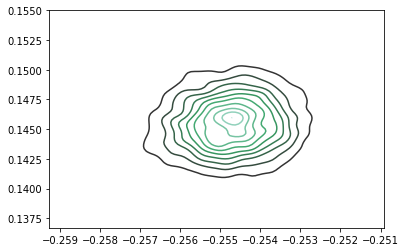

In [26]:
sns.kdeplot(ss[:,0], ss[:,1])
plt.show()

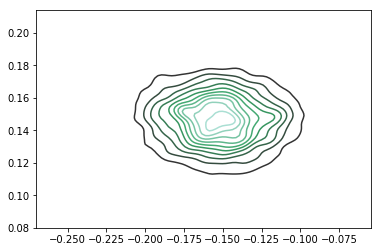

In [24]:
sns.kdeplot(ss[:,0], ss[:,1])
plt.show()

In [25]:
for epoch in range(epoch, epoch+1000):
    for step in range(100):
        sess.run(opt)
    print(kl.eval(), sigma.eval(), sp.eval())

1398.4525796702544 0.9017899974001534 [[0.31756846 0.30734717]]
1390.9950929842687 0.9042797439197203 [[0.62450445 0.64148583]]
1377.1655548887397 0.9028580594573996 [[0.57751483 0.81447612]]
1386.27115806484 0.9018807974246745 [[0.72376745 1.07405494]]
1390.2699666826875 0.9026810046574065 [[0.9140161  0.42807226]]


KeyboardInterrupt: 